# Food Delivery Time Prediction

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
import shap

%matplotlib inline

C:\Users\ADMIN\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Input

In [2]:
# Import data
df=pd.read_csv('food_delivery_time.csv')
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


## Data Exploration

In [3]:
# Basic info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [4]:
# Check NA values
df.isnull().sum()

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken(min)                0
dtype: int64

We have 20 features and 45593 rows

**From the above output, we can conclude and note that:**

- There are no missing values in this datasets
- Still some features that don't have correct datatypes like: Delivery_person_Age, Delivery_person_Ratings and multiple_deliveries, Time_taken(min), it is possible that there are non-numeric characters in this columns, causing the data to be converted to object format, except column Time_taken(min) because the phrase (min) appears.

In [5]:
# Check for strange characters appearing in the column
def check_invalid(col, reg=r'^[0-9]+$', replace_reg=r'[0-9]'):
    invalid_row=df[col][~df[col].str.match(reg)]
    invalid_count=invalid_row.count()

    invalid=df[col].str.replace(replace_reg, '', regex=True)
    invalid_char=set(invalid.str.cat())
    
    return invalid_char, invalid_count

In [6]:
check_invalid('Delivery_person_Age')

({' ', 'N', 'a'}, 1854)

In [7]:
check_invalid('Delivery_person_Ratings', reg=r'^[0-9.]+$', replace_reg=r'[0-9.]')

({' ', 'N', 'a'}, 1908)

In [8]:
check_invalid('multiple_deliveries')

({' ', 'N', 'a'}, 993)

We can see that there are non-numeric characters in the columns above, and the number of rows is also relatively small. However, to keep as many rows as possible for model training, we will remove these characters and use the Interpolation method to fill in the missing values ​​after removal.

In [9]:
# Replace invalid characters by null values
df['Delivery_person_Age']=df['Delivery_person_Age'].replace(r'[^0-9]', np.nan, regex=True)
df['Delivery_person_Ratings']=df['Delivery_person_Ratings'].replace(r'[^0-9.]', np.nan, regex=True)
df['multiple_deliveries']=df['multiple_deliveries'].replace(r'[^0-9]', np.nan, regex=True)

In [10]:
# Convert to numerical data type
df['Delivery_person_Age']=df['Delivery_person_Age'].astype('float')
df['Delivery_person_Ratings']=df['Delivery_person_Ratings'].astype('float')
df['multiple_deliveries']=df['multiple_deliveries'].astype('float')

# Use Interpolation technique to fill missing values
df['Delivery_person_Age'].interpolate(method='linear', inplace=True)
df['Delivery_person_Age']=df['Delivery_person_Age'].round()
df['Delivery_person_Ratings'].interpolate(method='linear', inplace=True)
df['Delivery_person_Ratings']=df['Delivery_person_Ratings'].round(1)
df['multiple_deliveries'].interpolate(method='linear', inplace=True)
df['multiple_deliveries']=df['multiple_deliveries'].round()

In [11]:
# Extract minutes from Time_taken columns
df['Time_taken(min)']=df['Time_taken(min)'].str.slice(start=6)
df['Time_taken(min)']=df['Time_taken(min)'].astype('int')

In [12]:
df.describe()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition,multiple_deliveries,Time_taken(min)
count,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000,45593.000000
mean,29.568552,4.633615,17.017729,70.231332,17.465186,70.845702,1.023359,0.740969,26.294607
std,5.756585,0.330867,8.185109,22.883647,7.335122,21.118812,0.839065,0.574026,9.383806
min,15.000000,1.000000,-30.905562,-88.366217,0.010000,0.010000,0.000000,0.000000,10.000000
25%,25.000000,4.500000,12.933284,73.170000,12.988453,73.280000,0.000000,0.000000,19.000000
50%,30.000000,4.700000,18.546947,75.898497,18.633934,76.002574,1.000000,1.000000,26.000000
75%,34.000000,4.800000,22.728163,78.044095,22.785049,78.107044,2.000000,1.000000,32.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,3.000000,3.000000,54.000000


A problem occurs that the latitude and longitude values ​​of Delivery_location are both positive values, while the latitude and longitude of Restaurant appear to be negative values, which shows that there may be a combination like A(-2,-3) and B(4,5), in this project, we will use the Haversine formula to calculate the distance between two points on the map. However, the combination of the coordinates of 2 points with both positive and negative values ​​will lead to very large distances, which is even more unreasonable in the context of food delivery, where a relatively close distance and fast delivery time are required. Therefore, we will convert the negative values ​​in the 2 columns longitude and latitude of Restaurant to positive values.

Although this calculation method will give the result as the crow flies (ie the shortest distance between 2 points), in reality it is difficult to find such a short route. Therefore, the actual distance is always greater than or equal to the calculated distance. From there, we will only use this distance as a factor affecting delivery time.

In [13]:
df['Restaurant_latitude']=np.where(df['Restaurant_latitude']<0, df['Restaurant_latitude']*-1, df['Restaurant_latitude'])
df['Restaurant_longitude']=np.where(df['Restaurant_longitude']<0, df['Restaurant_longitude']*-1, df['Restaurant_longitude'])

In [14]:
# Create some features
# Calculate the distance between restaurant and delivery location by using longitude and latitude and haversine formula

# Create function
def distance(lat_a, long_a, lat_b, long_b):
    df_copy=df.copy()
    for col in [lat_a, long_a, lat_b, long_b]:
        df_copy[col+'_rad']=df_copy[col]*np.pi/180
    df['distance'] = df_copy.apply(
        lambda row: haversine_distances([[row[lat_a+'_rad'], row[long_a+'_rad']], 
                                     [row[lat_b+'_rad'], row[long_b+'_rad']]])[0, 1],
        axis=1
        )
    df['distance'] = (df['distance']*6371).round(3)
    return df

In [15]:
df=distance('Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude')

Since we will be using features in the data to train the model, we will only take those features that are deemed necessary.

In [16]:
# Rename and drop redundant columns
df.rename(columns={'Time_taken(min)':'Time_taken'}, inplace=True)
df.drop(columns=['ID', 'Delivery_person_ID', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked'], inplace=True)

In [17]:
cat_cols=df.select_dtypes(include='object') # Get categorical columns
num_cols=df.select_dtypes(exclude='object') # Get numerical columns

In [18]:
for i in cat_cols.columns:
    print(f'Number of categories of {i}:\n', cat_cols[i].value_counts())

Number of categories of Weatherconditions:
 Weatherconditions
conditions Fog           7654
conditions Stormy        7586
conditions Cloudy        7536
conditions Sandstorms    7495
conditions Windy         7422
conditions Sunny         7284
conditions NaN            616
Name: count, dtype: int64
Number of categories of Road_traffic_density:
 Road_traffic_density
Low        15477
Jam        14143
Medium     10947
High        4425
NaN          601
Name: count, dtype: int64
Number of categories of Type_of_order:
 Type_of_order
Snack      11533
Meal       11458
Drinks     11322
Buffet     11280
Name: count, dtype: int64
Number of categories of Type_of_vehicle:
 Type_of_vehicle
motorcycle           26435
scooter              15276
electric_scooter      3814
bicycle                 68
Name: count, dtype: int64
Number of categories of Festival:
 Festival
No      44469
Yes       896
NaN       228
Name: count, dtype: int64
Number of categories of City:
 City
Metropolitian     34093
Urban      

It can be seen that in some categorical variables, phrase 'NaN' ​​appears such as Weatherconditions, Road_traffic_density, Festival, City, in addition, the Weatherconditions column has the same repeated phrase 'conditions' so we will remove that phrase to make the data simplest. We will remove the rows containing the phrase 'NaN' and replace them with the mode value of that column.

In [19]:
df['Weatherconditions']=df['Weatherconditions'].str.slice(start=11) # Remove 'condidtions' word in Weatherconditions columns
df['Weatherconditions']=df['Weatherconditions'].replace(r'.*NaN.*', np.nan, regex=True)
df['Road_traffic_density']=df['Road_traffic_density'].replace(r'.*NaN.*', np.nan, regex=True)
df['Festival']=df['Festival'].replace(r'.*NaN.*', np.nan, regex=True)
df['City']=df['City'].replace(r'.*NaN.*', np.nan, regex=True)

for col in cat_cols.columns:
    df[col]=df[col].fillna(value=df[col].mode()[0]) # Fill NaN values
    df[col]=df[col].str.strip() # Remove whitespaces

In [20]:
cat_cols=df.select_dtypes(include='object')

**Visualization to examine the data characteristics of each variable**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8012\668196018.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8012\668196018.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8012\668196018.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8012\668196018.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,i].set_xticklabels(ax[1

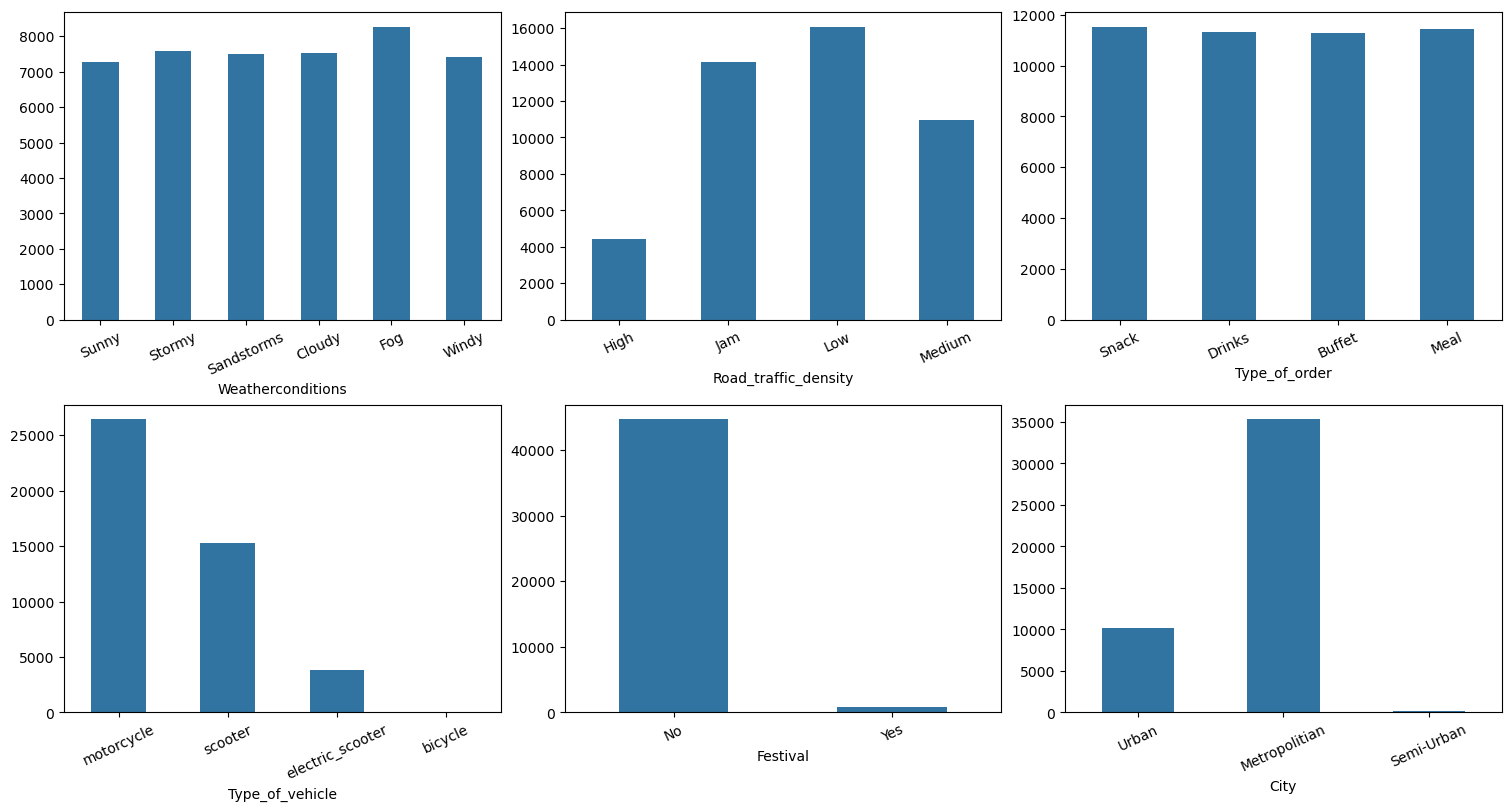

In [21]:
fig, ax=plt.subplots(2,3, figsize=(15,8), constrained_layout=True)
for i, col in enumerate(cat_cols.iloc[:,0:3]):
    sns.countplot(data=cat_cols, width=0.5, x=col, ax=ax[0,i])
    ax[0,i].set_ylabel(None)
    ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)
for i, col in enumerate(cat_cols.iloc[:,3:6]):
    sns.countplot(data=cat_cols, width=0.5, x=col, ax=ax[1,i])
    ax[1,i].set_ylabel(None)
    ax[1,i].set_xticklabels(ax[1,i].get_xticklabels(), rotation=25)

The number of values ​​in the Weatherconditions and Type_of_order categorical variables is quite even, while the remaining categorical variables have quite a large difference. For example, with Type_of_vehicle, delivery people mainly use motorbikes and scooters because of the speed and convenience they bring, or with City, people who order food delivery services are mainly in large and medium-sized urban areas rather than semi-urban areas.

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8012\2313760967.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8012\2313760967.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8012\2313760967.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8012\2313760967.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,i].set_xticklabels(

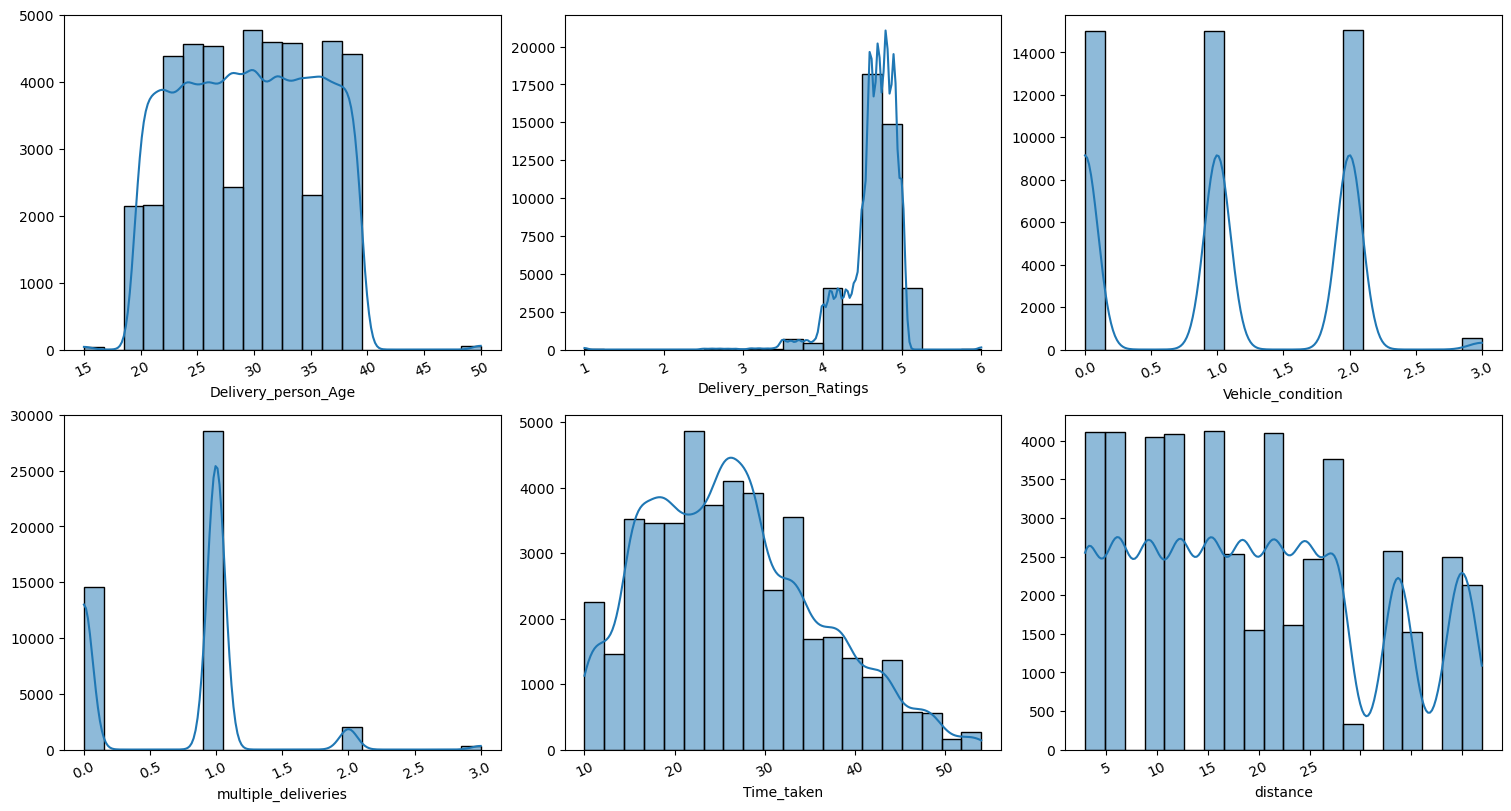

In [22]:
fig, ax=plt.subplots(2,3, figsize=(15,8), constrained_layout=True)
for i, col in enumerate(num_cols.iloc[:,0:3]):
    sns.histplot(data=num_cols, bins=20, kde=True, x=col, ax=ax[0,i])
    ax[0,i].set_ylabel(None)
    ax[0,i].set_xticklabels(ax[0,i].get_xticklabels(), rotation=25)
for i, col in enumerate(num_cols.iloc[:,3:6]):
    sns.histplot(data=num_cols, bins=20, kde=True, x=col, ax=ax[1,i])
    ax[1,i].set_ylabel(None)
    ax[1,i].set_xticklabels(ax[1,i].get_xticklabels(), rotation=25)

With continuous variables, we will check the distribution of the values ​​in the column, it can be seen that the values ​​have a relatively normal distribution, no variable has a very skewed distribution.

Since our purpose is to build a predictive model with the target variable Time_taken, we will need to examine the correlation between the independent variables and the dependent variable. For continuous independent variables, we will use Pearson correlation and use Oneway-ANOVA with categorical variables to examine the difference between groups in a categorical variable, thereby assessing whether that variable is correlated with the dependent variable.

<Axes: >

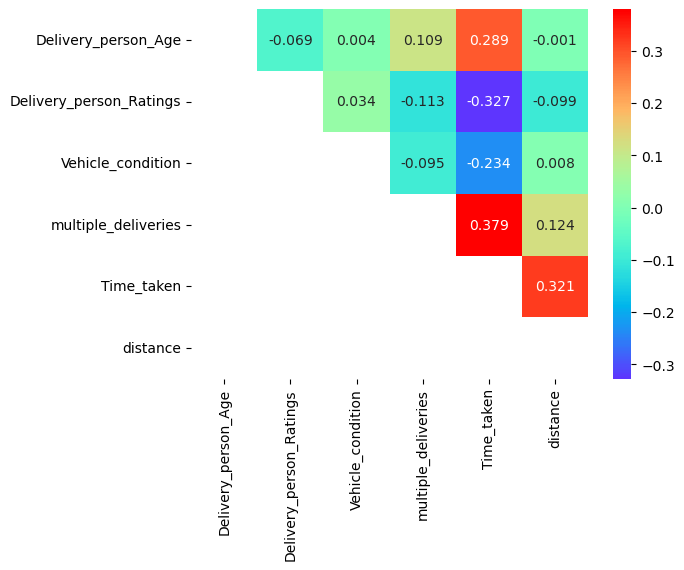

In [23]:
# Check correlation matrix
corr=df.corr(numeric_only=True)
mask=np.tril(corr)
sns.heatmap(corr, annot=True, mask=mask, cmap='rainbow', center=0, fmt='.3f')

With the above results, we see that most of the independent and dependent variables have an average correlation, in addition, there is a weak or very weak correlation between the independent variables to ensure that there is no multicollinearity phenomenon.

In [24]:
# Analysis of Variance for categorical features
from scipy.stats import f_oneway
grouped_data={}
for col in cat_cols.columns:
    grouped_data[col+'_grouped']=[group['Time_taken'].values for name, group in df.groupby(col)]
    f_statistic, p_value = f_oneway(*grouped_data[col + '_grouped'])
    print(f"Results for {col}:")
    print(f"F-statistic: {f_statistic:.4f}, P-value: {p_value:.4f}\n")

Results for Weatherconditions:
F-statistic: 599.3302, P-value: 0.0000

Results for Road_traffic_density:
F-statistic: 3309.6422, P-value: 0.0000

Results for Type_of_order:
F-statistic: 1.1699, P-value: 0.3195

Results for Type_of_vehicle:
F-statistic: 421.6862, P-value: 0.0000

Results for Festival:
F-statistic: 4187.7289, P-value: 0.0000

Results for City:
F-statistic: 1360.9768, P-value: 0.0000



For categorical variables, the ANOVA results show that except for the Type_of_order variable with p-value>0.5, the remaining variables show significant differences between groups in the categorical variables, from which it can be concluded that these variables are correlated with the dependent variable Time_taken. For the Type_of_order variable that has no correlation, we will remove it from the data.

In [25]:
# Remove variables 'Type_of_order' from data
data=df.drop(columns='Type_of_order')

## Data Preprocessing and Training

In [26]:
# Train-test split
from sklearn.model_selection import train_test_split
x=data.drop(columns='Time_taken')
y=data['Time_taken']

x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=1)

In [27]:
# Encoding data
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
x_train_en=pd.get_dummies(data=x_train, columns=['Weatherconditions', 'Type_of_vehicle', 'City'], dtype=int, drop_first=True)
x_test_en=pd.get_dummies(data=x_test, columns=['Weatherconditions', 'Type_of_vehicle', 'City'], dtype=int, drop_first=True)

x_train_en['Festival']=le.fit_transform(x_train_en['Festival'])
x_test_en['Festival']=le.transform(x_test_en['Festival'])
x_train_en['Road_traffic_density']=x_train_en['Road_traffic_density'].replace({'Low':0, 'Medium':1, 'High':2, 'Jam':3}).astype(int)
x_test_en['Road_traffic_density']=x_test_en['Road_traffic_density'].replace({'Low':0, 'Medium':1, 'High':2, 'Jam':3}).astype(int)

In [28]:
x_train_en.dtypes

Delivery_person_Age                 float64
Delivery_person_Ratings             float64
Road_traffic_density                  int32
Vehicle_condition                     int64
multiple_deliveries                 float64
Festival                              int32
distance                            float64
Weatherconditions_Fog                 int32
Weatherconditions_Sandstorms          int32
Weatherconditions_Stormy              int32
Weatherconditions_Sunny               int32
Weatherconditions_Windy               int32
Type_of_vehicle_electric_scooter      int32
Type_of_vehicle_motorcycle            int32
Type_of_vehicle_scooter               int32
City_Semi-Urban                       int32
City_Urban                            int32
dtype: object

In [29]:
# Scaling data
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
x_train_en_sc=scaler.fit_transform(x_train_en)
x_test_en_sc=scaler.transform(x_test_en)

x_train_en_sc=pd.DataFrame(data=x_train_en_sc, columns=x_train_en.columns)
x_test_en_sc=pd.DataFrame(data=x_test_en_sc, columns=x_train_en.columns)

In [30]:
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
regressors = [('LinearRegression', LinearRegression),
              ('RandomForestRegressor', RandomForestRegressor),
              ('XGBRegressor', XGBRegressor),
              ('LGBMRegressor', LGBMRegressor),
              ('DecisionTreeRegressor', DecisionTreeRegressor)]

lazy_model=LazyRegressor(verbose=0, ignore_warnings=True, regressors=regressors, predictions='True')
reg_model, predictions=lazy_model.fit(x_train_en_sc, x_test_en_sc, y_train, y_test)
reg_model

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:16<00:03,  3.32s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 36474, number of used features: 17
[LightGBM] [Info] Start training from score 26.307315


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.40s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.82,0.82,4.01,0.50
XGBRegressor,0.81,0.81,4.05,0.27
RandomForestRegressor,0.80,0.80,4.16,15.14
DecisionTreeRegressor,0.65,0.65,5.57,0.23
LinearRegression,0.57,0.57,6.13,0.88


From the above model training results, we see that the LGBMRegressor model gives the largest R^2 result, we will use this model as the main model.

## Model Evaluation

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 36474, number of used features: 17
[LightGBM] [Info] Start training from score 26.307315


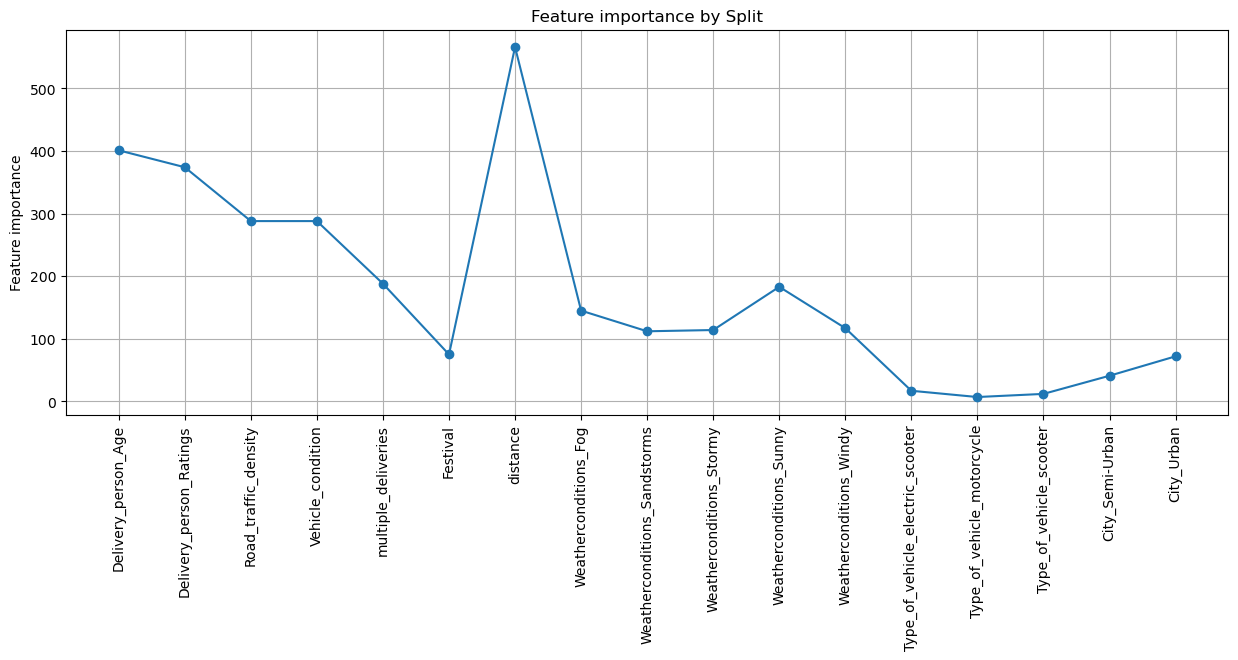

In [31]:
lgbm=LGBMRegressor()
lgbm.fit(x_train_en_sc, y_train)
coef=lgbm.feature_importances_

plt.figure(figsize=(15,5))
plt.plot(x_train_en_sc.columns, coef, marker='o')
plt.xticks(rotation=90)
plt.ylabel('Feature importance')
plt.title('Feature importance by Split')
plt.grid(True)

''

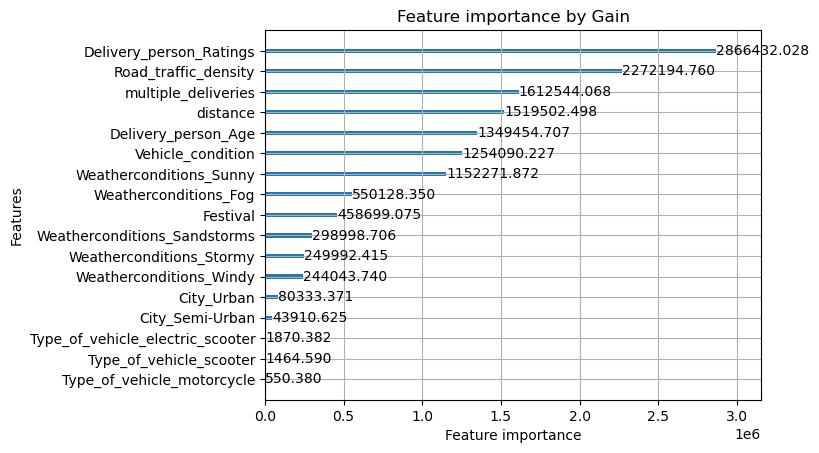

In [32]:
import lightgbm
lightgbm.plot_importance(lgbm, max_num_features=20, importance_type='gain')
plt.title("Feature importance by Gain")
;

The two graphs above show the results of the importance of each variable in the model in two different ways. With graph 1, it is based on Split, which means counting the number of times a variable is selected to split the data in the trees. The variable that is selected more often tends to be considered more important, because it tends to help classify the data more times. With graph 2, it is based on Gain, which means the amount of improvement that each variable contributes to the model when it is selected to split the data. Gain measures the importance based on how much better the variable helps the model predict. 

With the above results, although the number of times chosen to divide is the Distance variable, but to reflect the highest contribution of the variables to the model, the Delivery_person_Ratings variable accounts for the most, this is also quite true to reality because the delivery time mostly affects the delivery person's rating, so a person with a high rating means that person delivers quickly (ie low Time_taken) will satisfy customers.

''

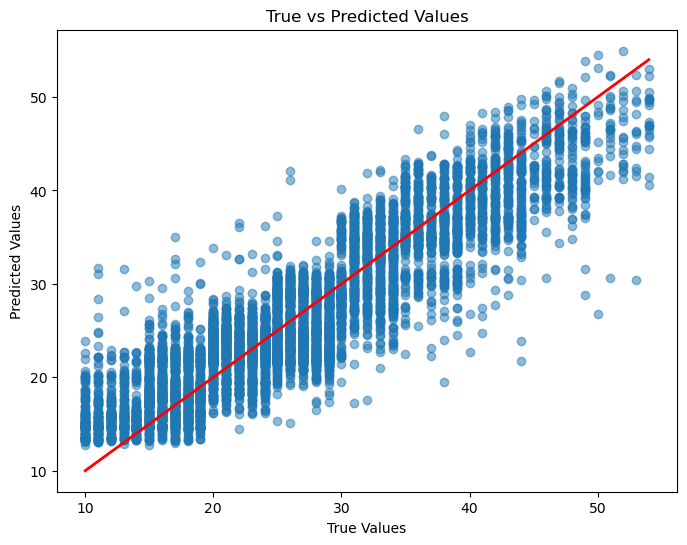

In [33]:
y_pred=lgbm.predict(x_test_en_sc)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
;

The above graph shows a comparison between the predicted values ​​and the actual values. The results show that the values ​​are quite close to the diagonal (the diagonal y=x shows the match between the predicted values ​​and the actual values). In addition, the distribution of the points is quite even and random around the diagonal, which shows that the model has good generalization ability.

''

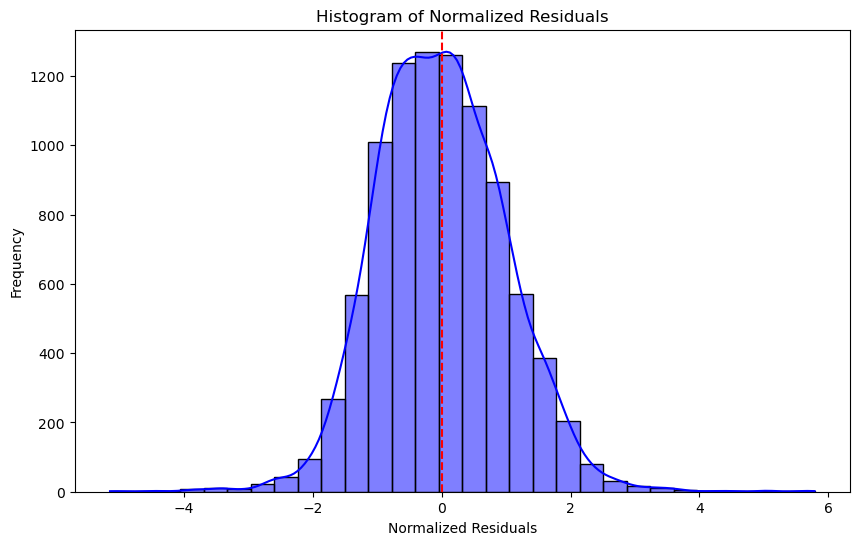

In [34]:
residuals = y_test-y_pred
normalized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(10, 6))
sns.histplot(normalized_residuals, bins=30, kde=True, color='blue')
plt.title('Histogram of Normalized Residuals')
plt.xlabel('Normalized Residuals')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--')
;

The above graph is used to evaluate the normal distribution of the residuals. It can be seen that the residuals have approximately normal distribution when they have a bell shape around the 0 axis, thereby showing that the hypothesis of a normally distributed residual model is not violated, ensuring the model is suitable.

''

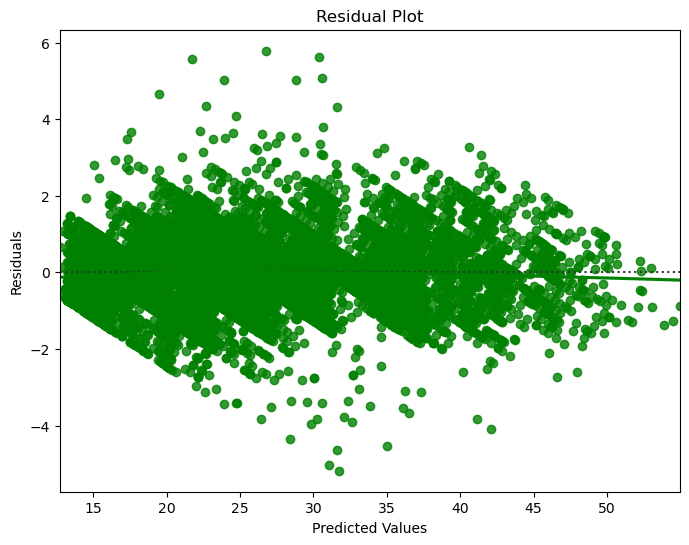

In [35]:
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=normalized_residuals, lowess=True, color="g")
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
;

The above graph helps to evaluate the validity of the model and identify potential problems. One of the assumptions of regression is homoscedasticity. This means that the dispersion of the residuals does not change with the predicted values. With the above results, the values ​​are around the horizontal line 0 and there is no increasing or decreasing trend, indicating that the model is performing well. However, the results also show that there are still some outliers that should be removed to achieve better results.

## Discussion

Because this project we use LightGBM model, this is also a very difficult model to interpret. Therefore, to find out the factors that have a big impact on delivery time, we will use SHAP to interpret.

In [36]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(x_train_en_sc)

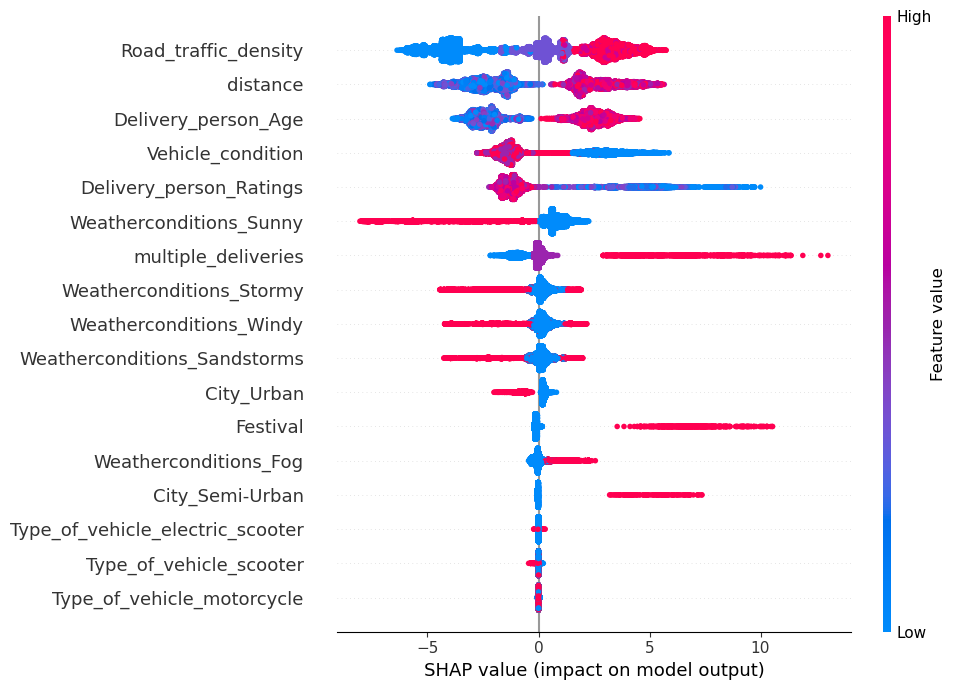

In [37]:
shap.summary_plot(shap_values, x_train_en_sc, plot_size=(10,7))

**Based on the above results, we can divide them into 3 main groups:**

**Variables with strong impact:**

- *Road_traffic_density:* This is the variable with the greatest impact on delivery time, shown by the first position on the chart. The SHAP value of this variable fluctuates strongly from negative to positive, indicating that depending on the traffic level (high, medium, low), delivery time can change significantly.
The red points (indicating high traffic density) are concentrated on the right side with positive SHAP values ​​indicating that when traffic density is high, delivery time tends to increase. Conversely, lower traffic density (blue) reduces delivery time.

- *Distance:* This is also a variable with a fairly large impact on delivery time with a fairly easy understanding: the farther the delivery distance, the longer the delivery time. Although this is the distance as the crow flies, in reality the distance is usually longer, which does not affect the practicality of this variable. More specifically, the influence is reflected by positive SHAP values ​​when the distance is large (red points) and negative SHAP values ​​when the distance is short (blue points).

- *Delivery_person_Age:* This variable has a significant impact with a fairly wide range of SHAP values. The age of the delivery person may affect the delivery speed, possibly due to the ability to handle deliveries more quickly in young age or more maturely in middle age. Higher values ​​(red) tend to have positive SHAP values, suggesting that older delivery people tend to increase delivery time, while younger people (blue) decrease time.

**Variables with medium impact:**
- *Vehicle_condition:*
- *Delivery_person_Ratings:*

**Variables with almost no impact:**
- *Festival:*
- *City*
- *Weather conditions (e.g., Sunny, Windy, Sandstorms)*

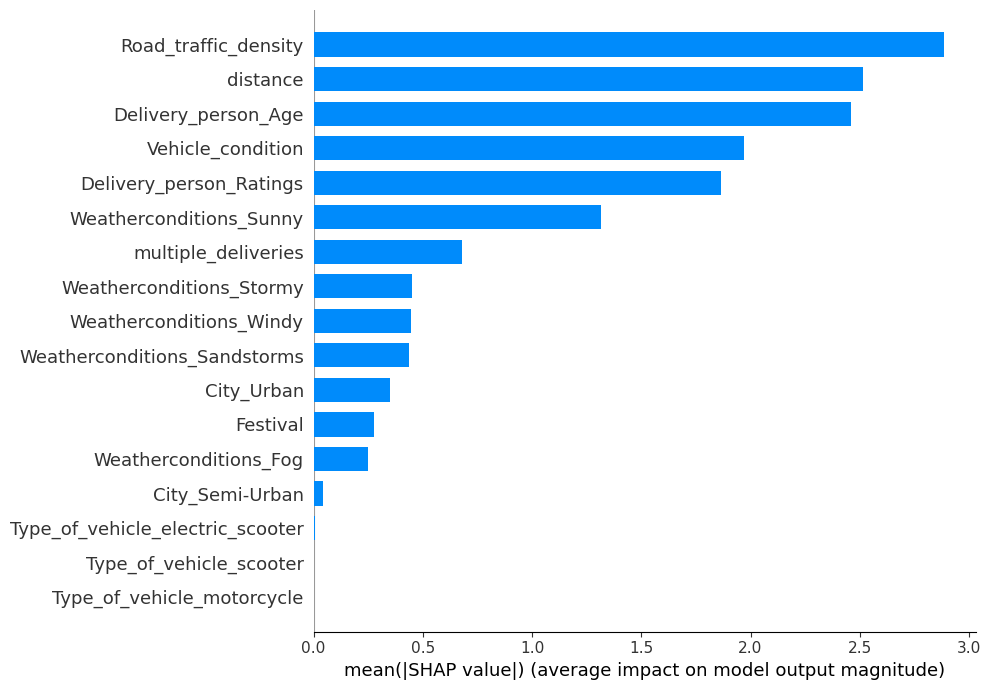

In [38]:
shap.summary_plot(shap_values, x_train_en_sc, plot_type="bar", plot_size=(10,7))

For a more general assessment, we can rely on the average value of SHAP value, we can see that 5 variables including: Road_traffic_density, Distance, Delivery_person_Age, Vehicle_condition, Delivery_person_Ratings are variables that have a relatively large impact on delivery time while Type_of_vehicle has almost no impact.

# End!